<a href = 'https://towardsdatascience.com/multiclass-classification-using-k-nearest-neighbours-ca5281a9ef76'>May</a> be helpful?


04 Apr 2022
Not sure if KNN is suitable for this analysis - a lot of the features are categorical and can't be replaced (e.g. race, sex, marital status, employment)
As per the first submission, I will remove categorical values for the first pass.

In [40]:
import pandas as pd
import numpy as np

In [41]:
pd.set_option("display.max_columns", 100)

In [42]:
features_path = 'C:/Users/Chloe.Dickinson/Documents/Python Scripts/Competitions/DrivenData/datasets/training_set_features.csv'
labels_path = "C:/Users/Chloe.Dickinson/Documents/Python Scripts/Competitions/DrivenData/datasets/training_set_labels.csv"

features_df = pd.read_csv(features_path, index_col = "respondent_id")
labels_df = pd.read_csv(labels_path, index_col = "respondent_id")

In [43]:
joined_df = features_df.join(labels_df)
print(joined_df.shape)
joined_df.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [44]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [113]:
numeric_cols = features_df.columns[features_df.dtypes != 'object'].values
#print(numeric_cols)

numeric_features_df = features_df[features_df.columns.intersection(numeric_cols)]

#### Perform preprocessing
Identify and impute missing values first of all

In [46]:
for x in numeric_cols:
    print(numeric_features_df[x].unique(), 'are unique values in', x)

[ 1.  3.  2.  0. nan] are unique values in h1n1_concern
[ 0.  2.  1. nan] are unique values in h1n1_knowledge
[ 0.  1. nan] are unique values in behavioral_antiviral_meds
[ 0.  1. nan] are unique values in behavioral_avoidance
[ 0.  1. nan] are unique values in behavioral_face_mask
[ 0.  1. nan] are unique values in behavioral_wash_hands
[ 0.  1. nan] are unique values in behavioral_large_gatherings
[ 1.  0. nan] are unique values in behavioral_outside_home
[ 1.  0. nan] are unique values in behavioral_touch_face
[ 0. nan  1.] are unique values in doctor_recc_h1n1
[ 0. nan  1.] are unique values in doctor_recc_seasonal
[ 0.  1. nan] are unique values in chronic_med_condition
[ 0.  1. nan] are unique values in child_under_6_months
[ 0.  1. nan] are unique values in health_worker
[ 1. nan  0.] are unique values in health_insurance
[ 3.  5.  4.  2.  1. nan] are unique values in opinion_h1n1_vacc_effective
[ 1.  4.  3.  2.  5. nan] are unique values in opinion_h1n1_risk
[ 2.  4.  1.  5.  3

In [47]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_cols_mode = Pipeline([('simple_imputer', SimpleImputer(strategy = 'most_frequent'))]
    )

Preprocessing of the numeric data will occur as part of the pipeline. It is not performed yet.

A special version of KNN, <a href = 'http://scikit.ml/api/skmultilearn.adapt.mlknn.html'>Multilabel k Nearest Neighbours</a>, has been developed. I'd love to take it for a spin but despite my best efforts, (pip installing the package, and checking install, 'ModuleNotFoundError: No module named 'skmultilearn'' is haunting me and I will use a usual KNN. Let's see how this goes.

## N_neighbors = 15

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

estimators = MultiOutputClassifier(estimator = KNeighborsClassifier(n_neighbors = 15)
)

In [49]:
full_pipeline = Pipeline(
    [('preprocessor', numeric_cols_mode),
     ('estimator', estimators)
    ]
                        )

In [50]:
full_pipeline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('simple_imputer',
                                  SimpleImputer(strategy='most_frequent'))])),
                ('estimator',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=15)))])

#### Training and Evaluation

Data will be split into train and test sets, use the stratify argument to enforce an even split.

In [51]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 88

X_train, X_test, y_train, y_test = train_test_split(numeric_features_df, 
                                                    labels_df,
                                                    test_size = 0.33,
                                                    shuffle = True,
                                                    stratify = labels_df,
                                                    random_state = 88
                                                    )

In [52]:
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('simple_imputer',
                                  SimpleImputer(strategy='most_frequent'))])),
                ('estimator',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=15)))])

In [53]:
preds = full_pipeline.predict_proba(X_test)
preds

[array([[1.        , 0.        ],
        [1.        , 0.        ],
        [0.86666667, 0.13333333],
        ...,
        [1.        , 0.        ],
        [0.73333333, 0.26666667],
        [0.8       , 0.2       ]]),
 array([[0.86666667, 0.13333333],
        [0.86666667, 0.13333333],
        [0.2       , 0.8       ],
        ...,
        [0.86666667, 0.13333333],
        [0.6       , 0.4       ],
        [0.66666667, 0.33333333]])]

In [54]:
y_preds = pd.DataFrame(
    {'h1n1_vaccine': preds[0][:, 1],
    'seasonal_vaccine': preds[1][:, 1]},
    index = y_test.index
)
print('y_preds.shape', y_preds.shape)
y_preds.head()

y_preds.shape (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
1028,0.000000,0.133333
1251,0.000000,0.133333
712,0.133333,0.800000
10165,0.466667,0.533333
26647,0.000000,0.066667


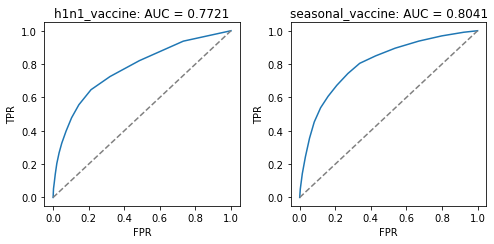

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )
    
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

0.77 and 0.80 aren't great. Maybe increase the # neghbours in another pass.

### Retrain model on whole dataset

In [56]:
full_pipeline.fit(numeric_features_df, labels_df)
None

In [57]:
test_features_df = pd.read_csv('C:/Users/Chloe.Dickinson/Documents/Python Scripts/Competitions/DrivenData/datasets/test_set_features.csv',
                              index_col = 'respondent_id')
test_features_df = test_features_df[test_features_df.columns.intersection(numeric_cols)]

In [58]:
test_probas_n_15 = full_pipeline.predict_proba(test_features_df)

In [20]:
submission_df = pd.read_csv('C:/Users/Chloe.Dickinson/Documents/Python Scripts/Competitions/DrivenData/datasets/submission_format.csv',
                           index_col = 'respondent_id')

In [21]:
np.testing.assert_array_equal(test_features_df.index.values,
                             submission_df.index.values)

In [22]:
submission_df['h1n1_vaccine'] = test_probas_n_15[0][:, 1]
submission_df['seasonal_vaccine'] = test_probas_n_15[1][:, 1]

In [23]:
submission_df.to_csv('fourth_submission_knn_n_15.csv', index = True)

The result from n_neighbors = 15 isn't great. I'm going to re run it using n_neighbors = x15 (15, 30, 45, 60, 75, 90, 105) to see if it improves. I won't use the full pipeline and instead just use numeric_cols_mode. With help from <a href = 'https://machinelearningknowledge.ai/knn-classifier-in-sklearn-using-gridsearchcv-with-example/#vii_Model_fitting_with_K-cross_Validation_and_GridSearchCV'>here</a>.

In [59]:
numeric_cols_mode = numeric_cols_mode.fit(numeric_features_df, labels_df)

In [60]:
knn = KNeighborsClassifier()

In [61]:
from sklearn.model_selection import GridSearchCV
num_neighbors = [15, 30, 45, 60, 75, 90, 105]
param_grid = dict(n_neighbors = num_neighbors)

In [62]:
grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy', return_train_score = False, verbose = 1)

quickly apply the imputer to the numeric_features_df.

In [114]:
def impute_modal_value(dataframe, column):
    imp = SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')
    dataframe.loc[:, (column)] = imp.fit_transform(dataframe.loc[:, ([column])])

In [115]:
for column in numeric_cols:
    impute_modal_value(numeric_features_df, column)

C:\Users\Chloe.Dickinson\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\Chloe.Dickinson\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\Chloe.Dickinson\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [84]:
X_train, X_test, y_train, y_test = train_test_split(numeric_features_df, 
                                                    labels_df,
                                                    test_size = 0.33,
                                                    shuffle = True,
                                                    stratify = labels_df,
                                                    random_state = 88
                                                    )

In [85]:
grid_search = grid.fit(X_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.9min finished


In [86]:
print(grid_search.best_params_)

{'n_neighbors': 15}


wow, all this for no improvement in params. Maybe steps of 15 is too many? I'll reduce it to steps of 7.

In [87]:
num_neighbors = [7, 14, 21, 28, 35, 42, 49]
param_grid = dict(n_neighbors = num_neighbors)
grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy', return_train_score = False, verbose = 1)

In [88]:
grid_search = grid.fit(X_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.7min finished


In [89]:
grid_search.best_params_

{'n_neighbors': 21}

In [90]:
num_neighbors = list(range(16, 27, 1))
param_grid = dict(n_neighbors = num_neighbors)
grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy', return_train_score = False, verbose = 1)

In [91]:
grid_search = grid.fit(X_train, y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  2.6min finished


In [92]:
grid_search.best_params_

{'n_neighbors': 17}

17 is the best # of neighbors! I was close with 15 as a random first guess. Lets retrain knn to 17, then make a fresh submission. Please scale the numeric_features_df too.

In [118]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_df_scaled = scaler.fit_transform(numeric_features_df)

In [124]:
test_features_df = test_features_df[test_features_df.columns.intersection(numeric_cols)]
for col in numeric_cols:
    impute_modal_value(test_features_df, col)
test_features_df.astype(dtype = 'int64')

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,,,
26707,2,2,0,1,0,1,1,0,1,0,0,0,0,0,1,5,1,1,5,1,1,1,0
26708,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,1,4,1,1,3,0
26709,2,2,0,0,1,1,1,1,1,0,0,0,0,0,1,5,4,2,5,4,4,1,0
26710,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,4,2,2,4,4,2,1,0
26711,3,1,1,1,0,1,1,1,1,0,0,0,0,1,1,5,2,4,4,4,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1,1,0,1,0,1,0,0,1,1,1,0,0,0,1,4,2,2,4,2,1,1,1
53411,3,1,0,1,0,1,1,1,1,0,0,0,0,1,0,4,1,1,5,2,2,1,3
53412,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4,3,1,4,3,1,1,0


In [125]:
knn = KNeighborsClassifier(n_neighbors = 17)
knn.fit(numeric_df_scaled, labels_df)
test_probas_n_17 = knn.predict_proba(test_features_df)

In [126]:
test_probas_n_17

[array([[0.64705882, 0.35294118],
        [0.76470588, 0.23529412],
        [0.41176471, 0.58823529],
        ...,
        [0.47058824, 0.52941176],
        [0.47058824, 0.52941176],
        [0.52941176, 0.47058824]]),
 array([[0.35294118, 0.64705882],
        [0.29411765, 0.70588235],
        [0.17647059, 0.82352941],
        ...,
        [0.29411765, 0.70588235],
        [0.23529412, 0.76470588],
        [0.17647059, 0.82352941]])]

In [127]:
submission_df['h1n1_vaccine'] = test_probas_n_17[0][:, 1]
submission_df['seasonal_vaccine'] = test_probas_n_17[1][:,1]
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.352941,0.647059
26708,0.235294,0.705882
26709,0.588235,0.823529
26710,0.823529,0.941176
26711,0.411765,0.764706


In [128]:
submission_df.to_csv('submission_5_knn_n_17.csv', index=True)

upon submission, this version was 0.6683, by far the worst. I'm going to come back later and improve that. 